In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('../data/row_data.csv')

In [4]:
# Sort data by date
df = df.sort_values(by='date')

# Drop 'date' column for now
df = df.drop(['date'], axis=1)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [6]:
from joblib import dump

# Assuming 'scaler' is your MinMaxScaler object
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [20]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length + 1]
        X.append(seq[:-1])
        y.append(seq[-1][df.columns.get_loc("大盤_收盤價")])
    return np.array(X), np.array(y)

In [21]:
seq_length = 10  # for example, use the last 10 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing (80-20 split for example)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [22]:
demo_sequence = X_test[0]
demo_sequence = demo_sequence.reshape(1, seq_length - 1, X_train.shape[2])
demo_sequence

ValueError: cannot reshape array of size 320 into shape (1,9,32)

In [ ]:
y_test[0]

0.47464883953223863

In [23]:
# Model Creation
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
49/49 [==============================] - 4s 25ms/step - loss: 0.0124 - val_loss: 0.0232
Epoch 2/50
49/49 [==============================] - 1s 11ms/step - loss: 7.8879e-04 - val_loss: 0.0352
Epoch 3/50
49/49 [==============================] - 1s 11ms/step - loss: 5.3018e-04 - val_loss: 0.0315
Epoch 4/50
49/49 [==============================] - 1s 11ms/step - loss: 3.5106e-04 - val_loss: 0.0314
Epoch 5/50
49/49 [==============================] - 1s 11ms/step - loss: 2.6157e-04 - val_loss: 0.0278
Epoch 6/50
49/49 [==============================] - 1s 11ms/step - loss: 2.3486e-04 - val_loss: 0.0240
Epoch 7/50
49/49 [==============================] - 1s 11ms/step - loss: 2.2422e-04 - val_loss: 0.0276
Epoch 8/50
49/49 [==============================] - 1s 11ms/step - loss: 2.1815e-04 - val_loss: 0.0203
Epoch 9/50
49/49 [==============================] - 1s 11ms/step - loss: 2.1505e-04 - val_loss: 0.0203
Epoch 10/50
49/49 [==============================] - 1s 11ms/step - loss: 2.3

In [25]:
# Predictions
predictions = model.predict(X_test)

25/25 [==============================] - 1s 3ms/step


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [27]:
# For Regression
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.007080381398016039
Mean Absolute Error: 0.06810349310682332


In [28]:
# For Classification (predicting up or down movements)
y_test_direction = np.where(np.diff(y_test) >= 0, 1, 0)
predictions_direction = np.where(np.diff(predictions[:, 0]) >= 0, 1, 0)

accuracy = accuracy_score(y_test_direction, predictions_direction)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 54.35%


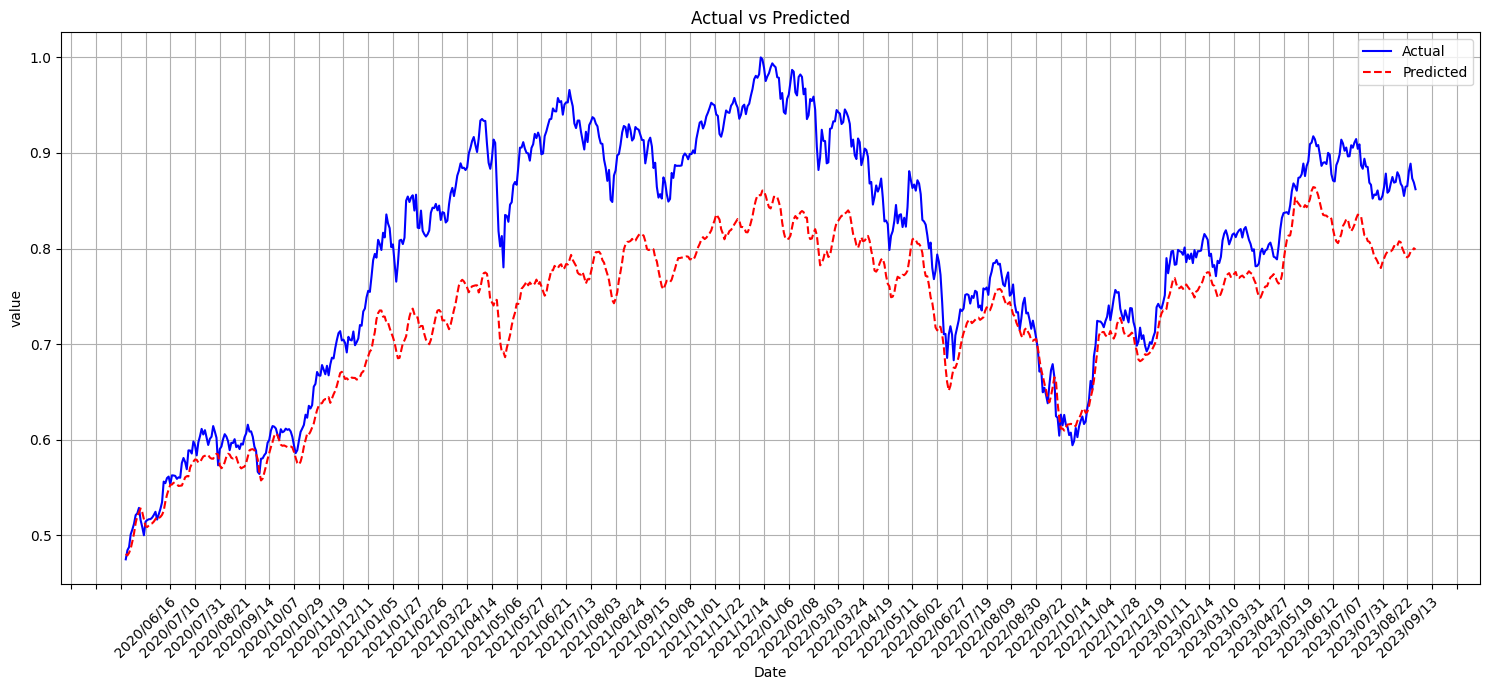

In [34]:
df = pd.read_csv('../data/row_data.csv')
dates = df['date'].values[-len(y_test):]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(dates, y_test, label="Actual", color='blue')
plt.plot(dates, predictions, label="Predicted", color='red', linestyle='dashed')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.tight_layout()
plt.show()

In [30]:
model.save("LSTM_tomorrow.h5")

c:\Users\overf\anaconda3\envs\StockMarketIndexAI\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
loaded_model = tf.keras.models.load_model('LSTM_v1.h5')